In [1]:
import numpy as np
z_DV, DV_rd, DV_rd_err = np.loadtxt('Data/Combine_DV_rd.dat', unpack=True)
z_DM, DM_rd, DM_rd_err = np.loadtxt('Data/Combine_DM_rd.dat', unpack=True)

In [2]:
# z_BAO, mb, mb_err = np.loadtxt('Output/m_b_reconstruct_results.txt', unpack=True)
z_BAO, mb, mb_err = np.loadtxt('Output/m_b_reconstruct(GPR)_results.txt', unpack=True)
z_DV = z_BAO[:3]
z_DM = z_BAO[3:]
mB_DV_bar_BAO = mb[:3]
mB_DV_bar_BAO_err = mb_err[:3]
mB_DM_bar_BAO = mb[3:]
mB_DM_bar_BAO_err = mb_err[3:]
_, H_pred_DV, H_std_DV = np.loadtxt('Output/Hz_DVreconstruct_results.txt', unpack=True)

In [3]:
def D_tau(z, DM_rd, DM_rd_err, mB, mB_err):
    """
    计算相邻红移区间的透明度变化 Δtau_i，并处理红移排序

    参数：
        z           : numpy array, 红移
        DM_rd       : numpy array, D_M / r_d 值
        DM_rd_err   : numpy array, D_M / r_d 的误差
        mB          : numpy array, 视星等 m_B
        mB_err      : numpy array, m_B 的误差

    返回：
        delta_tau       : numpy array, 每个区间 Δtau_i
        delta_tau_err   : numpy array, Δtau_i 的误差
        z_bin_center    : numpy array, 每个 Δtau_i 的中心红移
    """
    import numpy as np

    ln10_over_2p5 = np.log(10) / 2.5

    # 排序索引
    sort_idx = np.argsort(z)

    # 对所有数组排序
    z = z[sort_idx]
    DM_rd = DM_rd[sort_idx]
    DM_rd_err = DM_rd_err[sort_idx]
    mB = mB[sort_idx]
    mB_err = mB_err[sort_idx]

    # 差分计算
    delta_mb = mB[1:] - mB[:-1]
    delta_mb_err = np.sqrt(mB_err[1:]**2 + mB_err[:-1]**2)
    print(delta_mb, delta_mb_err)

    dm_ratio = DM_rd[1:] / DM_rd[:-1]
    dm_ratio_err = dm_ratio * np.sqrt((DM_rd_err[1:] / DM_rd[1:])**2 + (DM_rd_err[:-1] / DM_rd[:-1])**2)

    z_ratio = (1 + z[1:]) / (1 + z[:-1])

    # log 项和误差
    log_term = 2.5 * np.log10((z_ratio * dm_ratio)**2)
    log_term_err = 2.5 / np.log(10) * 2 * (dm_ratio_err / dm_ratio)  # 误差传播
    # Δtau 及其误差
    delta_tau = ln10_over_2p5 * (delta_mb - log_term)
    delta_tau_err = ln10_over_2p5 * np.sqrt(delta_mb_err**2 + log_term_err**2)

    # Δtau 对应的中心红移
    z_bin_center = 0.5 * (z[1:] + z[:-1])

    return delta_tau, delta_tau_err, z_bin_center


In [4]:
delta_tau= D_tau(z_DM, DM_rd, DM_rd_err, mB_DM_bar_BAO, mB_DM_bar_BAO_err)

[0.7485598  0.84432088 0.48984738 0.25082324 0.93424751 0.31739014
 1.24694212] [0.00951054 0.0132691  0.01830938 0.02244454 0.03418097 0.04616027
 0.0748189 ]


In [5]:
def D_tau2(z, H, H_err, DV_rd, DV_rd_err, mB, mB_err):
    """
    计算相邻红移区间的透明度变化 Δtau_i（基于 D_V/r_d），并处理红移排序

    参数：
        z           : numpy array, 红移
        H           : numpy array, 哈勃参数 H(z)
        H_err       : numpy array, H(z) 的误差
        DV_rd       : numpy array, D_V / r_d 值
        DV_rd_err   : numpy array, D_V / r_d 的误差
        mB          : numpy array, 视星等 m_B
        mB_err      : numpy array, m_B 的误差

    返回：
        delta_tau       : numpy array, 每个区间 Δtau_i
        delta_tau_err   : numpy array, Δtau_i 的误差
        z_bin_center    : numpy array, 每个 Δtau_i 的中心红移
    """

    ln10_over_2p5 = np.log(10) / 2.5

    # 排序索引
    sort_idx = np.argsort(z)

    # 对所有数组排序
    z = z[sort_idx]
    H = H[sort_idx]
    H_err = H_err[sort_idx]
    DV_rd = DV_rd[sort_idx]
    DV_rd_err = DV_rd_err[sort_idx]
    mB = mB[sort_idx]
    mB_err = mB_err[sort_idx]

    # 差分计算
    delta_mb = mB[1:] - mB[:-1]
    delta_mb_err = np.sqrt(mB_err[1:]**2 + mB_err[:-1]**2)

    # 计算比值
    dv_ratio = DV_rd[1:] / DV_rd[:-1]
    dv_ratio_err = dv_ratio * np.sqrt((DV_rd_err[1:] / DV_rd[1:])**2 + (DV_rd_err[:-1] / DV_rd[:-1])**2)
    
    H_ratio = H[1:] / H[:-1]
    H_ratio_err = H_ratio * np.sqrt((H_err[1:] / H[1:])**2 + (H_err[:-1] / H[:-1])**2)
    
    z_term = z[:-1] / z[1:] * ((1 + z[1:]) / (1 + z[:-1]))**2

    # log 项和误差
    log_arg = z_term * H_ratio * dv_ratio**3
    log_term = 2.5 * np.log10(log_arg)
    log_term_err = 2.5 / np.log(10) * np.sqrt((H_ratio_err / H_ratio)**2 + 9 * (dv_ratio_err / dv_ratio)**2)  # 3^2 = 9 for (dv_ratio)^3

    # Δtau 及其误差
    delta_tau = ln10_over_2p5 * (delta_mb - log_term)
    delta_tau_err = ln10_over_2p5 * np.sqrt(delta_mb_err**2 + log_term_err**2)

    # Δtau 对应的中心红移
    z_bin_center = 0.5 * (z[1:] + z[:-1])

    return delta_tau, delta_tau_err, z_bin_center

In [6]:
delta_tau2 = D_tau2(z_DV, H_pred_DV, H_std_DV, DV_rd, DV_rd_err, mB_DV_bar_BAO, mB_DV_bar_BAO_err)

Delta_tau (mean) = 0.1437
Delta_tau (error via numerical propagation) = 0.0605
\begin{tabular}{ccc}
redshift $z$ & $\Delta\tau$ & $\sigma_{\Delta\tau}$ \\
\hline
0.1280 & -0.1392 & 0.1850 \\
0.2225 & 0.1486 & 0.1215 \\
0.3375 & 0.1437 & 0.0605 \\
0.4450 & -0.0582 & 0.0424 \\
0.6080 & 0.0450 & 0.0346 \\
0.7780 & 0.0551 & 0.1060 \\
0.8920 & -0.0599 & 0.1056 \\
1.1275 & 0.0026 & 0.0416 \\
1.4025 & -0.0441 & 0.0694 \\
1.9070 & 0.0725 & 0.0892 \\
\end{tabular}


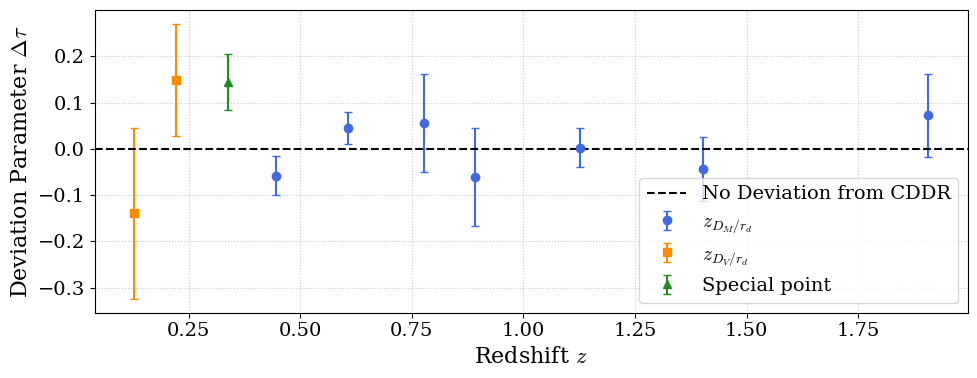

In [7]:
import numpy as np

# --- Input values (mean and error) ---
H_z2_val, H_z2_err = H_pred_DV[2], H_std_DV[2]
z3_val = z_BAO[3] # Assuming precise
DM_rd_z3_val, DM_rd_z3_err = DM_rd[0], DM_rd_err[0]
z2_val = z_BAO[2] # Assuming precise
DV_rd_z2_val, DV_rd_z2_err = DV_rd[2], DV_rd_err[2]
rd_val, rd_err = 147.09, 0.26
m3_val, m3_err = mb[3], mb_err[3]
m2_val, m2_err = mb[2], mb_err[2]
c_kms = 299792.458

# --- Function to calculate Delta_tau ---
def calculate_delta_tau(h_z2, dm_rd_z3, dv_rd_z2, rd, m3, m2, z2_p, z3_p, c_p):
    delta_mb_obs = m3 - m2
    
    term_denominator_log_val = (dv_rd_z2**3) * h_z2 * rd
    if abs(term_denominator_log_val) < 1e-12:
        return np.nan # Avoid division by zero

    term_numerator_log_val = (dm_rd_z3**2) * c_p * z2_p
    log_argument_val = term_numerator_log_val / term_denominator_log_val

    if log_argument_val <= 0:
        return np.nan # Avoid log of non-positive

    log_term_value_with_factor_val = 2.5 * np.log10(log_argument_val)
    redshift_ratio_sq_val = ((1 + z3_p) / (1 + z2_p))**2
    parentheses_term_val = delta_mb_obs - log_term_value_with_factor_val
    constant_factor_val = np.log(10) / 2.5
    
    return constant_factor_val * parentheses_term_val * redshift_ratio_sq_val

# --- Calculate mean value of Delta_tau ---
delta_tau_mean = calculate_delta_tau(H_z2_val, DM_rd_z3_val, DV_rd_z2_val, 
                                     rd_val, m3_val, m2_val, 
                                     z2_val, z3_val, c_kms)

# --- Numerically calculate partial derivatives and propagate error ---
variables_params = [
    (H_z2_val, H_z2_err, 'H_z2'),
    (DM_rd_z3_val, DM_rd_z3_err, 'DM_rd_z3'),
    (DV_rd_z2_val, DV_rd_z2_err, 'DV_rd_z2'),
    (rd_val, rd_err, 'rd'),
    (m3_val, m3_err, 'm3'),
    (m2_val, m2_err, 'm2'),
]

sum_of_squared_errors_contrib = 0
epsilon_scale = 1e-5 # Relative scale for epsilon, or use a small absolute value

base_args = {
    'h_z2': H_z2_val, 'dm_rd_z3': DM_rd_z3_val, 'dv_rd_z2': DV_rd_z2_val,
    'rd': rd_val, 'm3': m3_val, 'm2': m2_val,
    'z2_p': z2_val, 'z3_p': z3_val, 'c_p': c_kms
}

for val, err, name in variables_params:
    if err == 0: # Skip variables with no error
        continue

    args_plus = base_args.copy()
    args_minus = base_args.copy()
    
    # Choose epsilon carefully. A very small absolute epsilon might be better
    # if the variable value itself is small.
    epsilon = val * epsilon_scale if val !=0 else epsilon_scale # Avoid epsilon = 0 if val is 0
    if epsilon == 0 : epsilon = 1e-9 # Fallback if val and epsilon_scale product is 0

    args_plus[name.lower()] = val + epsilon # Match dict keys (lowercase)
    args_minus[name.lower()] = val - epsilon

    f_plus = calculate_delta_tau(**args_plus)
    f_minus = calculate_delta_tau(**args_minus)

    if np.isnan(f_plus) or np.isnan(f_minus):
        print(f"Warning: NaN encountered during partial derivative calculation for {name}. Error contribution for this variable might be inaccurate or skipped.")
        # Decide how to handle this: skip, or try a different epsilon, or assign a large error.
        # For simplicity, we'll skip its contribution if NaN.
        partial_derivative = 0
    elif abs(2*epsilon) < 1e-15: # Avoid division by very small number
         partial_derivative = 0
         print(f"Warning: Epsilon too small for {name}")
    else:
        partial_derivative = (f_plus - f_minus) / (2 * epsilon)
        
    sum_of_squared_errors_contrib += (partial_derivative**2) * (err**2)
    # print(f"Contribution from {name}: {(partial_derivative**2) * (err**2):.2e}, partial_deriv: {partial_derivative:.2e}")


if sum_of_squared_errors_contrib >= 0:
    delta_tau_error = np.sqrt(sum_of_squared_errors_contrib)
else:
    delta_tau_error = np.nan # Should not happen if calculations are correct
    print("Warning: sum_of_squared_errors_contrib is negative.")


# --- Simplified Output ---
print(f"Delta_tau (mean) = {delta_tau_mean:.4f}")
print(f"Delta_tau (error via numerical propagation) = {delta_tau_error:.4f}")

if np.isnan(delta_tau_mean) or np.isnan(delta_tau_error):
     print("Calculation resulted in NaN. Please check inputs and function for issues like division by zero or log of non-positive numbers at mean values or during derivative estimation.")
z3= (z_BAO[3]+ z_BAO[2])/2
z3

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'font.size': 14
})
plt.figure(figsize=(10, 4))
plt.errorbar(delta_tau[2], delta_tau[0], yerr=delta_tau[1], fmt='o', label=r'$z_{D_M/r_d}$',capsize=3,color='royalblue')
plt.errorbar(delta_tau2[2], delta_tau2[0], yerr=delta_tau2[1], fmt='s', label=r'$z_{D_V/r_d}$',capsize=3, color='darkorange')
plt.errorbar(z3, delta_tau_mean, delta_tau_error, fmt='^', label='Special point',capsize=3,color='forestgreen')
plt.axhline(0, color='k', linestyle='--', linewidth=1.5, label='No Deviation from CDDR')
plt.xlabel('Redshift $z$', fontsize=16)
plt.ylabel('Deviation Parameter $\\Delta \\tau$', fontsize=16) 
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.legend()
plt.savefig('fig/transparency(GPR).pdf', bbox_inches='tight')

z_median = np.concatenate([delta_tau2[2], np.array([z3]), delta_tau[2]])
dtau = np.concatenate([delta_tau2[0], np.array([delta_tau_mean]), delta_tau[0]])
dtau_err = np.concatenate([delta_tau2[1], np.array([delta_tau_error]), delta_tau[1]])

print("\\begin{tabular}{ccc}")
print("redshift $z$ & $\\Delta\\tau$ & $\\sigma_{\\Delta\\tau}$ \\\\")
print("\\hline")

for z, t, err in zip(z_median, dtau, dtau_err):
    print(f"{z:.4f} & {t:.4f} & {err:.4f} \\\\")

print("\\end{tabular}")
